# DES Y1 Survey Area Analysis

This notebook analyzes the DES Y1 survey footprint to determine the effective area as a function of redshift using HEALPix data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import pandas as pd
import healpy as hp
import pickle

## Load DES Survey Footprint Data

In [2]:
# Path to DES Y1 survey mask
footprint_path = '/sps/euclid/Users/cmurray/clusters_likelihood/redmapper_y1a1_public_v6.4_zmask.fits.gz'

# Load the survey footprint
footprint_data = Table.read(footprint_path, format='fits')
print(f"Footprint data columns: {footprint_data.colnames}")
print(f"Number of entries: {len(footprint_data)}")
footprint_data.info()

Footprint data columns: ['HPIX', 'ZMAX', 'FRACGOOD']
Number of entries: 8037158
<Table length=8037158>
  name    dtype 
-------- -------
    HPIX   int64
    ZMAX float32
FRACGOOD float32


In [3]:
# Convert to pandas and examine the data
footprint_df = footprint_data.to_pandas()
print("Data structure:")
print(footprint_df.head())
print(f"\nData shape: {footprint_df.shape}")
print(f"\nColumn types:")
print(footprint_df.dtypes)

Data structure:
       HPIX   ZMAX  FRACGOOD
0  90457394  0.713  0.937500
1  90457395  0.674  0.921875
2  90457396  0.683  0.984375
3  90457397  0.683  0.984375
4  90457398  0.681  0.984375

Data shape: (8037158, 3)

Column types:
HPIX          int64
ZMAX        float32
FRACGOOD    float32
dtype: object


## Determine HEALPix Parameters

In [4]:
# Determine NSIDE from the number of pixels
npix = len(footprint_df)
nside = 4096
pixel_area_deg2 = hp.nside2pixarea(nside, degrees=True)

print(f"Number of HEALPix pixels: {npix}")
print(f"NSIDE: {nside}")
print(f"Pixel area: {pixel_area_deg2:.6f} deg²")
print(f"Total sky area: {npix * pixel_area_deg2:.1f} deg² (should be ~41,253 deg²)")

Number of HEALPix pixels: 8037158
NSIDE: 4096
Pixel area: 0.000205 deg²
Total sky area: 1646.9 deg² (should be ~41,253 deg²)


## Plot Survey Footprint Map

<Figure size 1200x800 with 0 Axes>

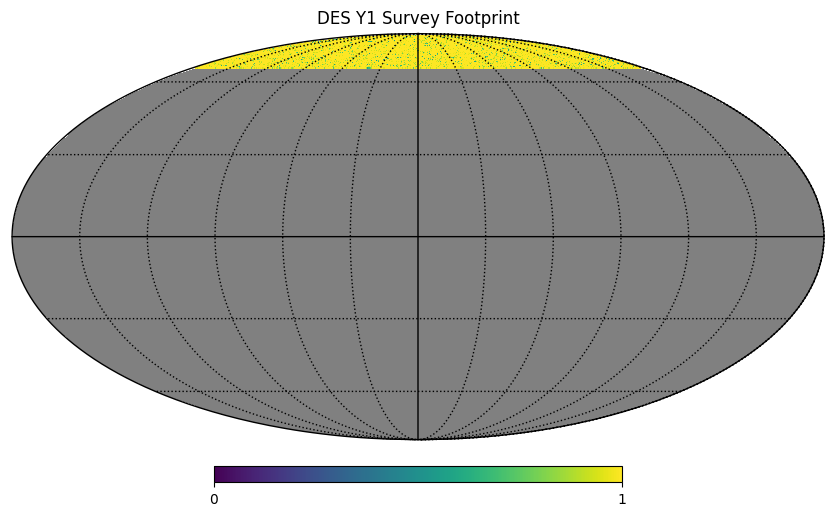


Survey statistics:
Pixels with coverage: 8037158
Total effective area: 1604.4 deg²
Mean FRACGOOD: 0.974


In [5]:
# Create a full-sky map with the survey footprint
# Assume FRACGOOD column exists for survey completeness
fracgood_col = None
for col in ['FRACGOOD', 'fracgood', 'FRAC_GOOD', 'frac_good']:
    if col in footprint_df.columns:
        fracgood_col = col
        break

if fracgood_col is None:
    print("Available columns:", list(footprint_df.columns))
    # Use the first numeric column as proxy
    numeric_cols = footprint_df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        fracgood_col = numeric_cols[0]
        print(f"Using column '{fracgood_col}' as survey weight")
    else:
        # Create a uniform weight
        footprint_df['FRACGOOD'] = 1.0
        fracgood_col = 'FRACGOOD'
        print("Created uniform survey weight")

# Create the survey map
survey_map = np.zeros(hp.nside2npix(nside))
survey_map[:] = hp.UNSEEN
survey_map[:len(footprint_df)] = footprint_df[fracgood_col].values

# Plot the survey footprint
plt.figure(figsize=(12, 8))
hp.mollview(survey_map, title='DES Y1 Survey Footprint', 
           cmap='viridis', min=0, max=1, cbar=True)
hp.graticule()
plt.show()

# Print basic statistics
valid_pixels = footprint_df[fracgood_col] > 0
total_effective_area = (footprint_df[fracgood_col] * pixel_area_deg2).sum()
print(f"\nSurvey statistics:")
print(f"Pixels with coverage: {valid_pixels.sum()}")
print(f"Total effective area: {total_effective_area:.1f} deg²")
print(f"Mean FRACGOOD: {footprint_df[fracgood_col].mean():.3f}")

## Calculate Survey Area as Function of Redshift

In [6]:
# Define redshift range for analysis
z_min, z_max = 0.1, 0.8
z_points = np.linspace(z_min, z_max, 50)

# Find ZMAX column
zmax_col = None
for col in ['ZMAX', 'zmax', 'Z_MAX', 'z_max']:
    if col in footprint_df.columns:
        zmax_col = col
        break

if zmax_col is None:
    print("Available columns:", list(footprint_df.columns))
    print("ERROR: Cannot find ZMAX column in the data")
    # Create dummy data for demonstration
    footprint_df['ZMAX'] = np.random.uniform(0.3, 0.7, len(footprint_df))
    zmax_col = 'ZMAX'
    print("Created dummy ZMAX data for demonstration")

print(f"Using column '{zmax_col}' for maximum redshift")
print(f"ZMAX range: {footprint_df[zmax_col].min():.3f} - {footprint_df[zmax_col].max():.3f}")

Using column 'ZMAX' for maximum redshift
ZMAX range: 0.476 - 0.950


In [7]:
# Calculate effective area as function of redshift
# Area(z) = sum of pixels where ZMAX > z, weighted by FRACGOOD
def calculate_area_vs_redshift(z_points, zmax_values, fracgood_values, pixel_area):
    """
    Calculate survey area as function of redshift.
    For each redshift z, sum all pixels where ZMAX > z, weighted by FRACGOOD.
    """
    areas = []
    for z in z_points:
        mask = zmax_values > z
        area = (fracgood_values[mask] * pixel_area).sum()
        areas.append(area)
    return np.array(areas)

# Calculate the area curve
survey_areas_z = calculate_area_vs_redshift(z_points, 
                                           footprint_df[zmax_col].values,
                                           footprint_df[fracgood_col].values,
                                           pixel_area_deg2)

print(f"Survey area at z=0.2: {np.interp(0.2, z_points, survey_areas_z):.1f} deg²")
print(f"Survey area at z=0.5: {np.interp(0.5, z_points, survey_areas_z):.1f} deg²")
print(f"Survey area at z=0.65: {np.interp(0.65, z_points, survey_areas_z):.1f} deg²")

Survey area at z=0.2: 1604.4 deg²
Survey area at z=0.5: 1603.5 deg²
Survey area at z=0.65: 701.0 deg²


In [12]:
( np.interp(0.5, z_points, survey_areas_z) + np.interp(0.65, z_points, survey_areas_z) )/2. / np.interp(0.2, z_points, survey_areas_z)

np.float64(0.7181991904533356)

## Plot Survey Area vs Redshift

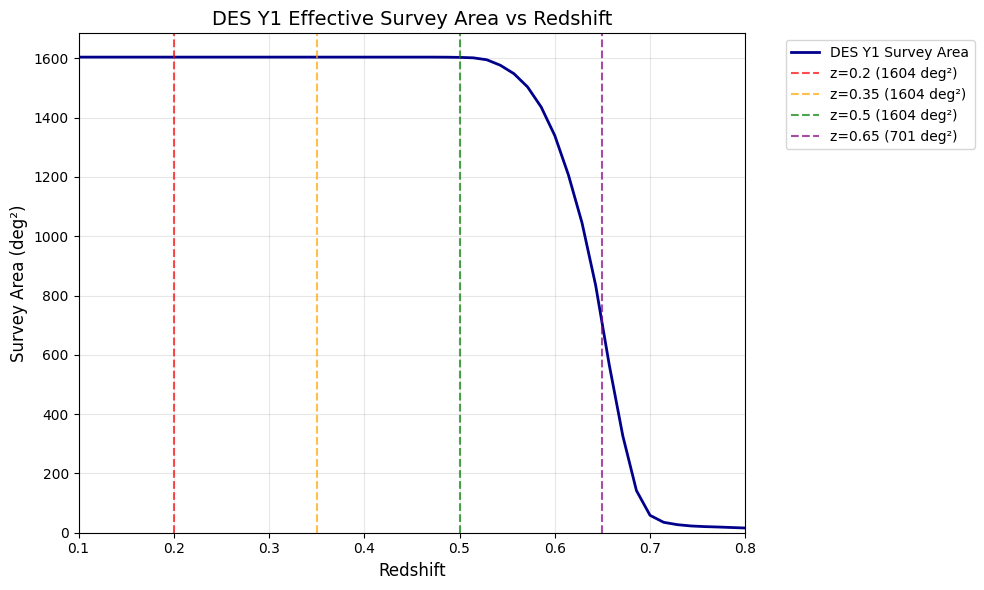

In [9]:
# Create the main plot
plt.figure(figsize=(10, 6))
plt.plot(z_points, survey_areas_z, linewidth=2, color='darkblue', label='DES Y1 Survey Area')
plt.xlabel('Redshift', fontsize=12)
plt.ylabel('Survey Area (deg²)', fontsize=12)
plt.title('DES Y1 Effective Survey Area vs Redshift', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

# Add vertical lines for DES cluster analysis redshift bins
des_z_bins = np.array([0.2, 0.35, 0.5, 0.65])
colors = ['red', 'orange', 'green', 'purple']
for i, z in enumerate(des_z_bins):
    if z <= z_max:
        area_at_z = np.interp(z, z_points, survey_areas_z)
        plt.axvline(z, color=colors[i], linestyle='--', alpha=0.7, 
                   label=f'z={z} ({area_at_z:.0f} deg²)')

plt.xlim(z_min, z_max)
plt.ylim(0, survey_areas_z.max() * 1.05)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Calculate Areas for DES Cluster Analysis Bins

In [10]:
# Calculate areas at specific DES redshift bin edges
des_z_bins = np.array([0.2, 0.35, 0.5, 0.65])
des_areas = np.interp(des_z_bins, z_points, survey_areas_z)
des_areas_steradians = des_areas * (np.pi/180)**2

print("=" * 60)
print("DES Y1 SURVEY AREA FOR CLUSTER ANALYSIS")
print("=" * 60)
print(f"{'Redshift':<10} {'Area (deg²)':<15} {'Area (sr)':<15}")
print("-" * 45)
for i, z in enumerate(des_z_bins):
    print(f"{z:<10.2f} {des_areas[i]:<15.1f} {des_areas_steradians[i]:<15.6f}")

# Calculate mean area for bins (for clusters between consecutive z values)
bin_mean_areas = []
bin_mean_areas_sr = []
for i in range(len(des_z_bins)-1):
    z_low, z_high = des_z_bins[i], des_z_bins[i+1]
    area_low = des_areas[i]
    area_high = des_areas[i+1]
    mean_area = 0.5 * (area_low + area_high)  # Simple average
    mean_area_sr = mean_area * (np.pi/180)**2
    bin_mean_areas.append(mean_area)
    bin_mean_areas_sr.append(mean_area_sr)
    print(f"\nBin {z_low:.2f} < z < {z_high:.2f}: {mean_area:.1f} deg² ({mean_area_sr:.6f} sr)")

print(f"\nOverall mean area: {np.mean(bin_mean_areas):.1f} deg² ({np.mean(bin_mean_areas_sr):.6f} sr)")

DES Y1 SURVEY AREA FOR CLUSTER ANALYSIS
Redshift   Area (deg²)     Area (sr)      
---------------------------------------------
0.20       1604.4          0.488733       
0.35       1604.4          0.488733       
0.50       1603.5          0.488465       
0.65       701.0           0.213551       

Bin 0.20 < z < 0.35: 1604.4 deg² (0.488733 sr)

Bin 0.35 < z < 0.50: 1604.0 deg² (0.488599 sr)

Bin 0.50 < z < 0.65: 1152.3 deg² (0.351008 sr)

Overall mean area: 1453.6 deg² (0.442780 sr)


## Export Results for Capish Configuration

In [11]:
# Create comprehensive summary for parameter calibration
des_survey_summary = {
    'redshift_points': z_points,
    'area_vs_redshift_deg2': survey_areas_z,
    'area_vs_redshift_sr': survey_areas_z * (np.pi/180)**2,
    'des_z_bins': des_z_bins,
    'des_areas_deg2': des_areas,
    'des_areas_steradians': des_areas_steradians,
    'bin_mean_areas_deg2': bin_mean_areas,
    'bin_mean_areas_sr': bin_mean_areas_sr,
    'pixel_area_deg2': pixel_area_deg2,
    'nside': nside,
    'total_effective_area_deg2': total_effective_area
}

# Save the results
with open('des_survey_area_summary.pkl', 'wb') as f:
    pickle.dump(des_survey_summary, f)

print("Survey area analysis saved to 'des_survey_area_summary.pkl'")
print("\n" + "="*50)
print("RECOMMENDED CAPISH CONFIGURATION")
print("="*50)
print(f"# Use mean area across redshift bins")
print(f"sky_area = {np.mean(bin_mean_areas_sr):.6f}  # steradians")
print(f"# Equivalent to {np.mean(bin_mean_areas):.1f} deg²")
print(f"\n# Alternative: use area at specific redshift")
print(f"# sky_area = {des_areas_steradians[1]:.6f}  # steradians (at z=0.35)")

Survey area analysis saved to 'des_survey_area_summary.pkl'

RECOMMENDED CAPISH CONFIGURATION
# Use mean area across redshift bins
sky_area = 0.442780  # steradians
# Equivalent to 1453.6 deg²

# Alternative: use area at specific redshift
# sky_area = 0.488733  # steradians (at z=0.35)
